# Combining ReacLib Rates with Electron Capture Tables

Here's an example of using tabulated weak rates from <cite data-cite-t="suzuki:2016">Suzuki et al. (2016)</cite> together with rates from the ReacLib database.

We'll build a network suitable for e-capture supernovae.

In [1]:
import pynucastro as pyna

First create a library from ReacLib using a set of nuclei.

In [2]:
reaclib_library = pyna.ReacLibLibrary()

all_nuclei = ["p", "he4",
              "ne20", "o20", "f20",
              "mg24", "al27", "o16",
              "si28", "s32", "p31"]
ecsn_library = reaclib_library.linking_nuclei(all_nuclei,with_reverse=True)

Here are the rates it chose

In [3]:
print(ecsn_library)

O16 + He4 ⟶ Ne20 + 𝛾           [Q =   4.73 MeV] (O16 + He4 --> Ne20 <co10_reaclib__>)
O16 + O16 ⟶ He4 + Si28         [Q =   9.59 MeV] (O16 + O16 --> He4 + Si28 <cf88_reaclib__>)
O16 + O16 ⟶ p + P31            [Q =   7.68 MeV] (O16 + O16 --> p + P31 <cf88_reaclib__>)
O20 ⟶ F20 + e⁻ + 𝜈             [Q =   3.81 MeV] (O20 --> F20 <wc12_reaclib_weak_>)
F20 ⟶ Ne20 + e⁻ + 𝜈            [Q =   7.02 MeV] (F20 --> Ne20 <wc12_reaclib_weak_>)
Ne20 + He4 ⟶ Mg24 + 𝛾          [Q =   9.32 MeV] (Ne20 + He4 --> Mg24 <il10_reaclib__>)
Mg24 + He4 ⟶ Si28 + 𝛾          [Q =   9.98 MeV] (Mg24 + He4 --> Si28 <st08_reaclib__>)
Al27 + p ⟶ He4 + Mg24          [Q =   1.60 MeV] (Al27 + p --> He4 + Mg24 <il10_reaclib__>)
Al27 + p ⟶ Si28 + 𝛾            [Q =  11.59 MeV] (Al27 + p --> Si28 <il10_reaclib__>)
Al27 + He4 ⟶ P31 + 𝛾           [Q =   9.67 MeV] (Al27 + He4 --> P31 <ths8_reaclib__>)
Si28 + He4 ⟶ S32 + 𝛾           [Q =   6.95 MeV] (Si28 + He4 --> S32 <ths8_reaclib__>)
P31 + p ⟶ He4 + Si28           [Q =   1.92 M

Now let's specify the weak rates we want from <cite data-cite-t="suzuki:2016">Suzuki et al.</cite> -- these tables are included with pynucastro:

In [4]:
tabular_lib = pyna.TabularLibrary()

In [5]:
ecsn_tabular = tabular_lib.linking_nuclei(["f20", "o20", "ne20"])

Let's look at the rates

In [6]:
tr = ecsn_tabular.get_rates()
tr

[F20 ⟶ Ne20 + e⁻ + 𝜈,
 F20 + e⁻ ⟶ O20 + 𝜈,
 Ne20 + e⁻ ⟶ F20 + 𝜈,
 O20 ⟶ F20 + e⁻ + 𝜈]

These tables are in terms of $T$ and $\rho Y_e$.  We can easily plot the tabulated electron capture rates just like ReacLib rates:

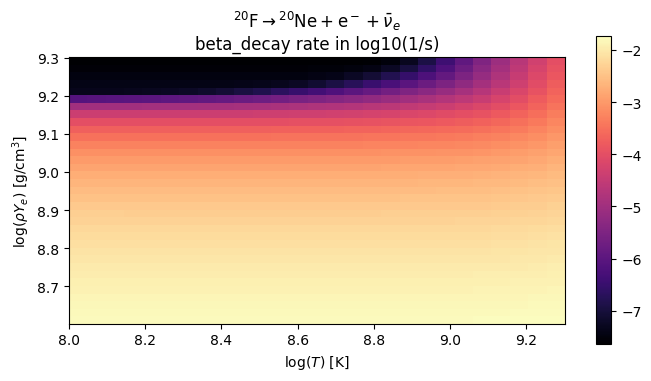

In [7]:
fig = tr[0].plot(rhoYmin=4.e8, rhoYmax=2.e9, Tmin=1.e8, Tmax=2.e9,
                 figsize=(8, 4))

Let's create a rate collection from just the ReacLib rates and look to see which are actually important

In [8]:
rc = pyna.RateCollection(libraries=[ecsn_library])

Here we'll pick thermodynamic conditions appropriate to the oxygen burning shell in a white dwarf

In [9]:
comp = pyna.Composition(rc.get_nuclei())
comp.set_nuc("o16", 0.5)
comp.set_nuc("ne20", 0.3)
comp.set_nuc("mg24", 0.1)
comp.set_nuc("o20", 1.e-5)
comp.set_nuc("f20", 1.e-5)
comp.set_nuc("p", 1.e-5)
comp.set_nuc("he4", 1.e-2)
comp.set_nuc("al27", 1.e-2)
comp.set_nuc("si28", 1.e-2)
comp.set_nuc("s32", 1.e-2)
comp.set_nuc("p31", 1.e-2)
comp.normalize()

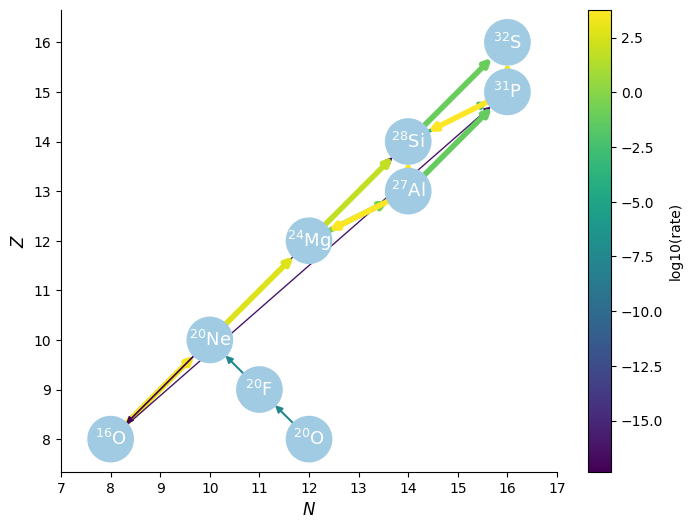

In [10]:
fig = rc.plot(rho=7.e9, T=1.e9, comp=comp, ydot_cutoff_value=1.e-20)

Note, this rate collection already includes some weak rates from ReacLib -- we want to remove those.

We'll also take the opportunity to remove any rates that are not important, by looking for a $|\dot{Y}| > 10^{-20}~s^{-1}$.

In [11]:
new_rate_list = []
ydots = rc.evaluate_rates(rho=7.e9, T=1.e9, composition=comp)
for rate in rc.rates:
    if abs(ydots[rate]) >= 1.e-20 and not rate.weak:
        new_rate_list.append(rate)        

Now let's add the tabular rates to this pruned down rate list

In [12]:
new_rate_list += tr

Finally, we'll create a new rate collection by combining this new list of rates with the list of tables:

In [13]:
rc_new = pyna.RateCollection(rates=new_rate_list)

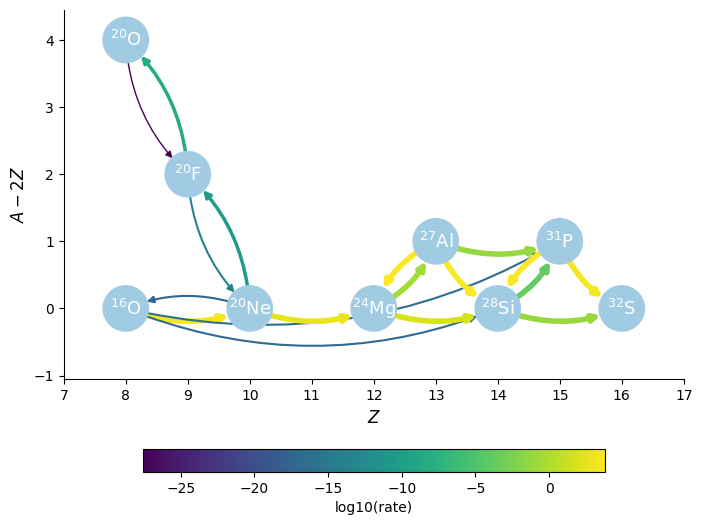

In [14]:
fig = rc_new.plot(rho=7.e9, T=1.e9, comp=comp, curved_edges=True, rotated=True)

We can see the values of the rates at our thermodynamic conditions easily:

In [15]:
rc_new.evaluate_rates(rho=7.e9, T=1.e9, composition=comp)

{Ne20 ⟶ He4 + O16: 4.6316695198155e-18,
 O16 + He4 ⟶ Ne20 + 𝛾: 2163.4896055892,
 Ne20 + He4 ⟶ Mg24 + 𝛾: 470.46571662959457,
 Mg24 + He4 ⟶ Si28 + 𝛾: 65.33425925449085,
 Al27 + p ⟶ Si28 + 𝛾: 3786.588954080847,
 Al27 + He4 ⟶ P31 + 𝛾: 0.05763581125914332,
 Si28 + He4 ⟶ S32 + 𝛾: 0.08322738610569612,
 P31 + p ⟶ S32 + 𝛾: 2375.1304964039123,
 O16 + O16 ⟶ p + P31: 7.15493989546395e-17,
 O16 + O16 ⟶ He4 + Si28: 2.5949312230335824e-17,
 Mg24 + He4 ⟶ p + Al27: 0.2543862399303773,
 Al27 + p ⟶ He4 + Mg24: 5920.818449985259,
 Si28 + He4 ⟶ p + P31: 0.00019528201299493384,
 P31 + p ⟶ He4 + Si28: 5491.960442675607,
 F20 ⟶ Ne20 + e⁻ + 𝜈: 1.143049854823845e-14,
 F20 + e⁻ ⟶ O20 + 𝜈: 4.212096660029042e-09,
 Ne20 + e⁻ ⟶ F20 + 𝜈: 4.3100255627801964e-11,
 O20 ⟶ F20 + e⁻ + 𝜈: 2.688308786951095e-28}

Additionally, we can see the specific energy generation rate for these conditions

In [16]:
rc_new.evaluate_energy_generation(rho=7.e9, T=1.e9, composition=comp)

9.667025588667893e+22